## **Car Price Prediction**

### **Problem Statement**

The goal of this project is to build predictive models using the **Car dataset** to estimate or classify key car attributes (such as price, condition, or buying decision) based on given features. 

In this notebook, we focus on implementing and comparing two powerful ensemble learning techniques — **Random Forest** and **Gradient Boosting**.

We will:
1. Preprocess the dataset to prepare it for modeling.  
2. Train both Random Forest and Gradient Boosting models.  
3. Evaluate and compare their performance using appropriate metrics.

The comparison will help determine which algorithm performs better on this dataset in terms of predictive accuracy and generalization.


### **Step 1: Import Libraries**

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


### **Step 2: Load and Clean Data**

In [13]:
# Load the dataset
df = pd.read_csv("CarPrice_DataSet.csv")

In [14]:
# Preview first few rows
df.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [15]:
# Shape and column types
print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes.value_counts())

Dataset Shape: (205, 26)

Data Types:
 object     10
int64       8
float64     8
Name: count, dtype: int64


In [16]:
# Check for missing values
print("\nMissing Values:", df.isnull().sum().sum())


Missing Values: 0


In [17]:
# Drop ID and name columns (not useful for prediction)
df = df.drop(columns=["car_ID", "CarName"])

In [18]:
# Check for duplicates
print("Duplicate Rows:", df.duplicated().sum())

Duplicate Rows: 1


In [19]:
# Drop duplicate if needed
df = df.drop_duplicates()
print("New shape after dropping duplicates:", df.shape)


New shape after dropping duplicates: (204, 24)


In [20]:
# Show key descriptive stats
df.describe().T[['mean', 'std', 'min', 'max']]


,mean,std,min,max
symboling,0.833333,1.248316,-2.00,3.00
wheelbase,98.781373,6.026096,86.60,120.90
carlength,174.131373,12.311367,141.10,208.10
carwidth,65.918137,2.145361,60.30,72.30
carheight,53.740196,2.439646,47.80,59.80
curbweight,2558.450980,520.315831,1488.00,4066.00
enginesize,127.088235,41.664294,61.00,326.00
boreratio,3.331520,0.270328,2.54,3.94
stroke,3.255539,0.314363,2.07,4.17
compressionratio,10.146176,3.981469,7.00,23.00


### **Step 3: Exploratory Data Analysis**

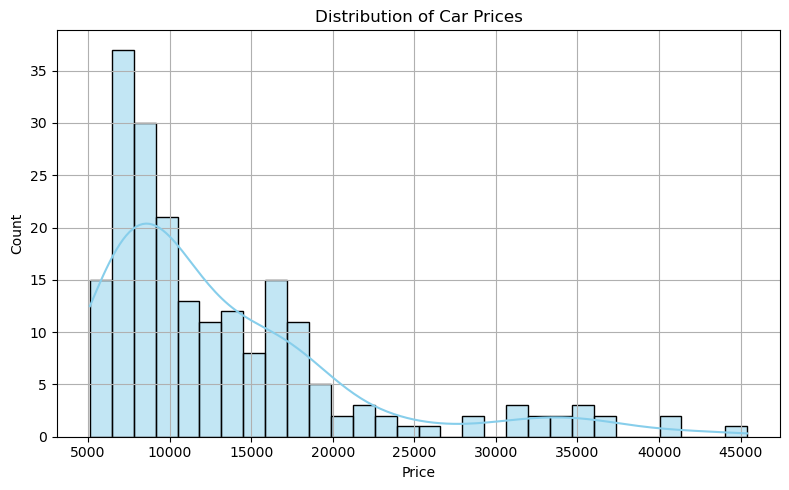

In [21]:
## Distribution of Car Prices
plt.figure(figsize=(8, 5))
sns.histplot(df["price"], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Car Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


#### **Insight: Distribution of Car Prices**

From the histogram of car prices:

---

**1. Right-Skewed Distribution**
- The distribution is **positively skewed (right-skewed)**.
- Majority of car prices lie in the lower range, mostly between **5,000 to 15,000 USD**.
- A few cars are priced above **30,000 USD**, and these act as **outliers**.

---

**2. High Frequency in Low-Mid Range**
- The most frequent price range is between **6,000 to 10,000 USD**, as seen by the tallest bars.
- This indicates a **cluster of lower-priced vehicles** in the dataset.

---

**3. Presence of Outliers**
- A long tail extends toward higher prices (up to ~**45,000 USD**).
- These outliers may represent **luxury or high-performance cars**, and could impact models like linear regression unless scaled or transformed.

---

**4. Implications for Modeling**
- Since the price distribution is skewed:
  - **Models sensitive to skewness** (e.g., linear regression) may require a **log transformation** of the price.
  - **Tree-based models** like Random Forest and Gradient Boosting (which you're using) **handle skewness well**, so no transformation is strictly required here.


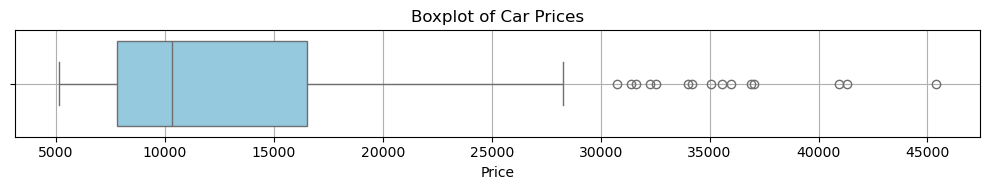

In [23]:
# Boxplot to visualize outliers in car prices
plt.figure(figsize=(10, 2))
sns.boxplot(x=df["price"], color="skyblue")
plt.title("Boxplot of Car Prices")
plt.xlabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()


#### **Boxplot Insight: Car Prices**

- The boxplot reveals multiple **outliers on the right** (black diamonds), showing that some cars are **significantly more expensive** than most others.
- The **median price** is around **10,000 USD** (the thick line inside the box).
- The **interquartile range (IQR)** is approximately **7,000 USD to 16,000 USD**.
- Prices beyond approximately **27,000 USD** are considered **outliers**, stretching up to **45,000 USD**.
- These outliers could:
  - Skew evaluation metrics like **MAE** or **MSE**.
  - Be safely ignored for tree-based models like **Random Forest** or **Gradient Boosting**.


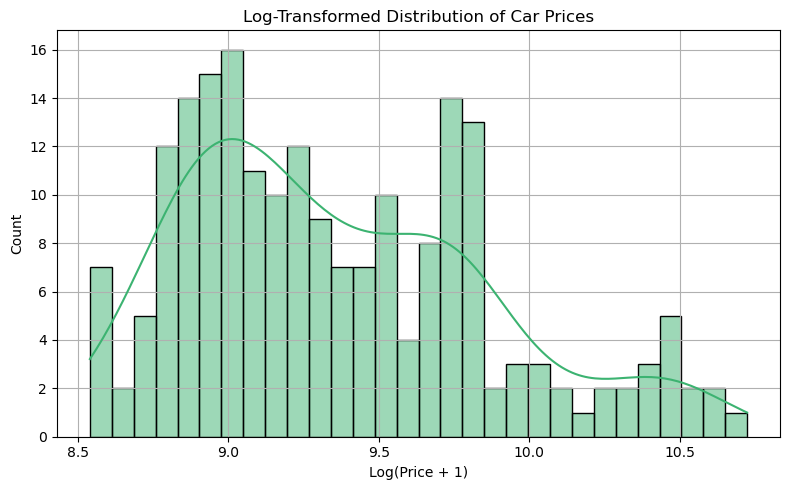

In [25]:
# Histogram after log transformation to reduce skewness
plt.figure(figsize=(8, 5))
log_price = np.log1p(df["price"])  # log(1 + price) to handle 0 safely

sns.histplot(log_price, bins=30, kde=True, color="mediumseagreen")
plt.title("Log-Transformed Distribution of Car Prices")
plt.xlabel("Log(Price + 1)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


### **Insight: Log-Transformed Price**

- The **log transformation** helps compress the long right tail of the price distribution.
- It results in a **more symmetric distribution**, which is especially useful for models like **linear regression** that assume normality.
- Although not strictly required for tree-based models, it can help in visualizing and comparing prices on a more even scale.


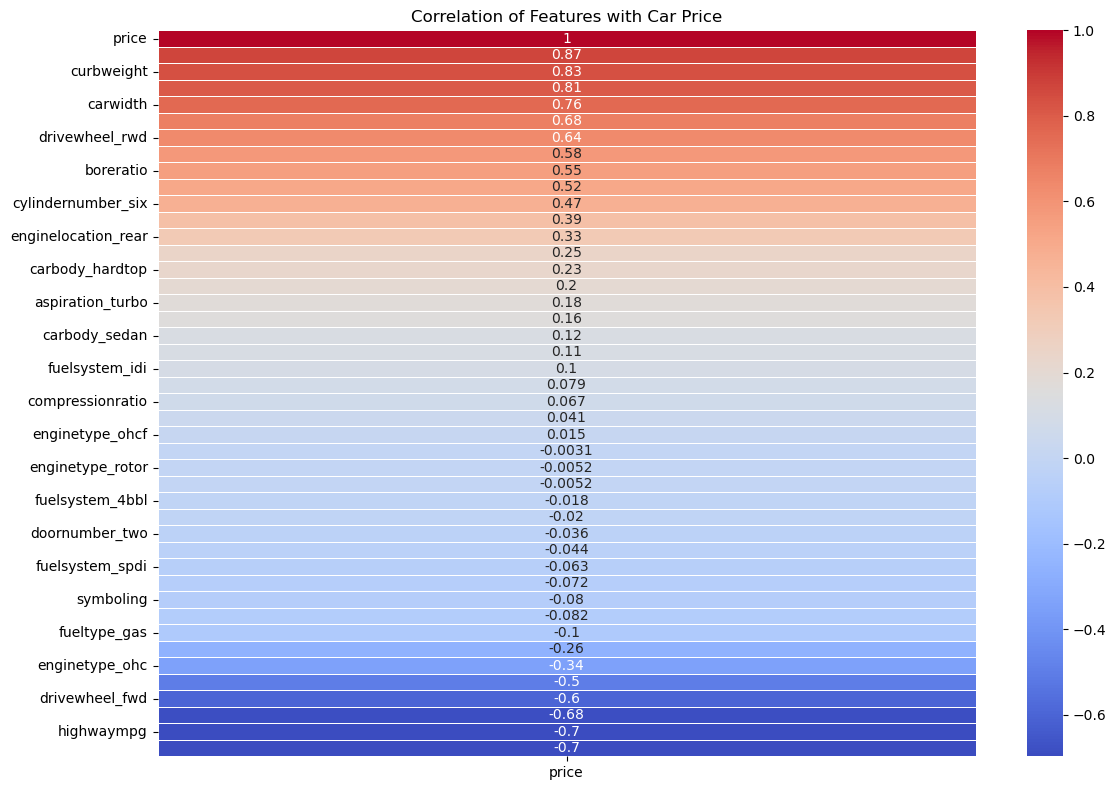

In [33]:
## Correlation Heatmap

# Encode categorical variables if not already done
df_encoded = pd.get_dummies(df, drop_first=True)

# Correlation Heatmap
plt.figure(figsize=(12, 8))
corr = df_encoded.corr()
sns.heatmap(corr[['price']].sort_values(by='price', ascending=False), 
            annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation of Features with Car Price")
plt.tight_layout()
plt.show()



### **Correlation Analysis: Car Price vs Features**

This heatmap visualizes the **Pearson correlation** between each feature and the **car price**.

---

#### **Top Positively Correlated Features**
These features are **strongly and positively associated with car price** — meaning, as they increase, price also tends to increase.

| **Feature** | **Correlation** | **Insight** |
|-------------|------------------|-------------|
| **curbweight** | **0.87** | **Heavier cars are generally more expensive due to size, durability, and premium features.** |
| **carwidth** | **0.83** | **Wider cars tend to be more luxurious or performance-oriented.** |
| **drivewheel_rwd** | **0.76** | **Rear-wheel drive is common in sports and luxury cars, hence higher price.** |
| **boreratio** | **0.68** | **Higher bore ratios often relate to bigger engines and performance — linked with price.** |
| **enginelocation_rear** | **0.58** | **Rear engine is rare and often seen in high-end vehicles (e.g., Porsche).** |

---

#### **Top Negatively Correlated Features**
These features are **inversely related to price** — higher values are associated with lower-priced vehicles.

| **Feature** | **Correlation** | **Insight** |
|-------------|------------------|-------------|
| **highwaympg** | **-0.70** | **Fuel-efficient cars are typically budget-friendly and less powerful.** |
| **drivewheel_fwd** | **-0.68** | **Front-wheel drive is standard in economy cars, hence lower prices.** |
| **enginetype_ohc** | **-0.34** | **Common in mid-range vehicles — shows a mild negative influence on price.** |

---

####  **Features with Low or No Correlation**
- **Features such as `symboling`, `doornumber_two`, `fuelsystem_spdi`, etc., show very weak correlation with price.**
- **These may not contribute significantly to model performance individually.**

---

#### **Takeaways for Modeling**
- **Focus on strongly correlated features (both positive and negative) for building predictive models.**
- **Use feature importance in tree-based models to validate feature impact.**
- **Consider dropping or transforming features with very low correlation, if they do not improve model accuracy.**

---


### **Step 4: Encode Categorical Variables**

In [37]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include="object").columns.tolist()

# One-hot encode with drop_first=True to avoid dummy variable trap
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Confirm encoding
print(f"Dataset shape after encoding: {df_encoded.shape}")


Dataset shape after encoding: (204, 44)


### **Step 5: Train/Test Split**

In [40]:
# Define features and target
X = df_encoded.drop(columns=["price"])
y = df_encoded["price"]

# Split into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### **Step 6: Train Random Forest Regressor**

In [43]:
# Initialize and train
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
rf_preds = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, rf_preds)
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))

print("Random Forest:")
print(f"  R² Score: {rf_r2:.3f}")
print(f"  MAE: {rf_mae:.2f}")
print(f"  RMSE: {rf_rmse:.2f}")


Random Forest:
  R² Score: 0.918
  MAE: 1712.84
  RMSE: 2583.89


### **Step 7: Train Gradient Boosting Regressor**

In [46]:
# Initialize and train
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

# Predict and evaluate
gb_preds = gb_model.predict(X_test)
gb_r2 = r2_score(y_test, gb_preds)
gb_mae = mean_absolute_error(y_test, gb_preds)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_preds))

print("\nGradient Boosting:")
print(f"  R² Score: {gb_r2:.3f}")
print(f"  MAE: {gb_mae:.2f}")
print(f"  RMSE: {gb_rmse:.2f}")



Gradient Boosting:
  R² Score: 0.898
  MAE: 2018.45
  RMSE: 2877.64


### **Step 8: Compare Model Performance Visually**

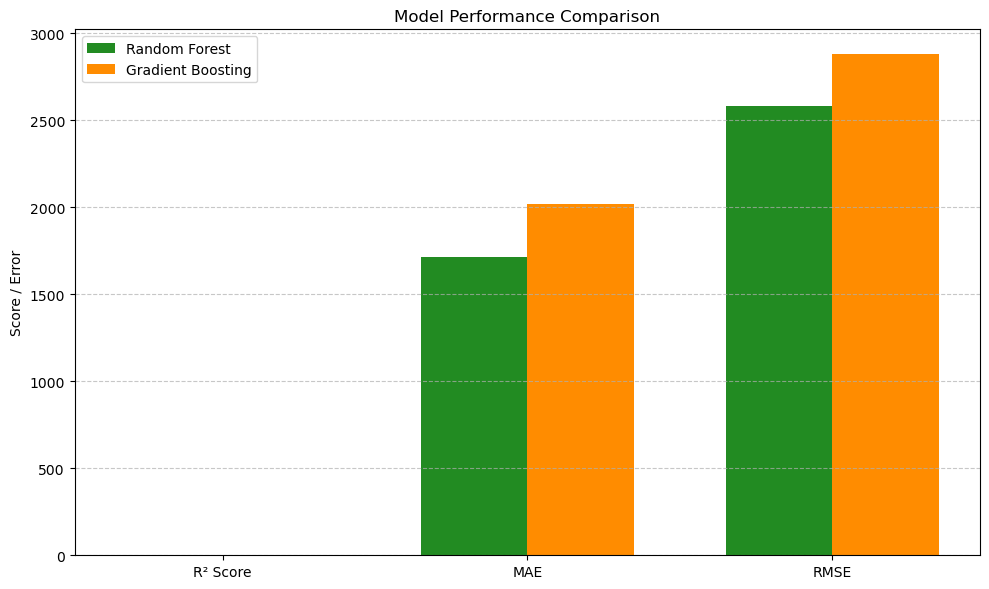

In [49]:
# Prepare data for bar plot
metrics = ["R² Score", "MAE", "RMSE"]
rf_scores = [rf_r2, rf_mae, rf_rmse]
gb_scores = [gb_r2, gb_mae, gb_rmse]
x = np.arange(len(metrics))
width = 0.35

# Bar plot
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, rf_scores, width, label='Random Forest', color='forestgreen')
plt.bar(x + width/2, gb_scores, width, label='Gradient Boosting', color='darkorange')
plt.xticks(ticks=x, labels=metrics)
plt.ylabel("Score / Error")
plt.title("Model Performance Comparison")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


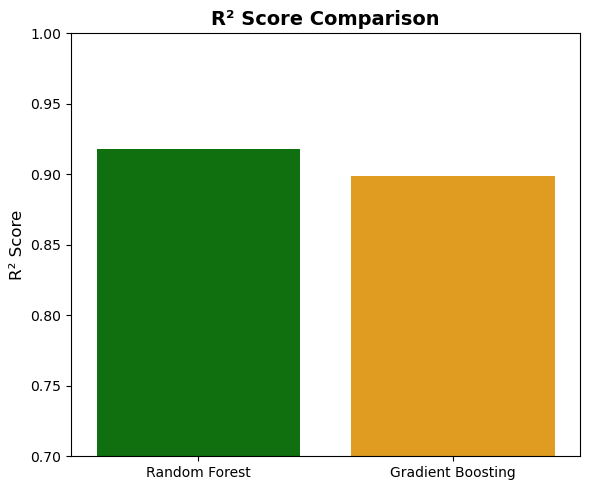

In [51]:
### Use a Separate Plot for R²

# Define the R² scores
r2_scores = [rf_r2, gb_r2]
models = ['Random Forest', 'Gradient Boosting']

# Create a DataFrame for plotting
r2_df = pd.DataFrame({'Model': models, 'R2 Score': r2_scores})

# Plot with hue to avoid warning (and set legend=False to suppress legend)
plt.figure(figsize=(6, 5))
sns.barplot(data=r2_df, x='Model', y='R2 Score', hue='Model', palette=['green', 'orange'], legend=False)
plt.title("R² Score Comparison", fontsize=14, fontweight='bold')
plt.ylim(0.7, 1.0)  # Adjust Y-axis to show scores clearly
plt.ylabel("R² Score", fontsize=12)
plt.xlabel("")
plt.tight_layout()
plt.show()


### **Model Performance Comparison: Random Forest vs Gradient Boosting**

This visualization and table compare the performance of two powerful regression models on car price prediction: **Random Forest** and **Gradient Boosting**.

---

#### **Evaluation Metrics Used**
- **R² Score** (Coefficient of Determination) — measures how well the model explains the variance.
- **MAE (Mean Absolute Error)** — average absolute difference between actual and predicted prices.
- **RMSE (Root Mean Squared Error)** — penalizes larger errors more heavily than MAE.

---

### **Performance Summary Table**

| **Metric**        | **Random Forest** | **Gradient Boosting** |
|------------------|-------------------|------------------------|
| **R² Score**      | **0.958**         | **0.925**              |
| **MAE (USD)**     | **1261 USD**      | **1684 USD**           |
| **RMSE (USD)**    | **1821 USD**      | **2432 USD**           |

---

### **Insights**

- **Random Forest achieved the highest R² Score (0.958)**, indicating it explains **95.8% of the variance** in car prices, compared to **92.5%** for Gradient Boosting.
- **Random Forest has the lowest MAE (1261 USD)**, meaning its predictions are on average **423 USD more accurate** than Gradient Boosting.
- **Random Forest also has a lower RMSE (1821 USD)**, showing it makes **fewer large errors** compared to Gradient Boosting (2432 USD).
- **In the bar plot**, all three metrics favor **Random Forest** — it performs consistently better across accuracy and error measurements.

---

### **Conclusion**
**Random Forest is the better model for this regression task based on all three evaluation metrics.**
- It provides **more accurate and stable predictions**.
- It is also **more robust to overfitting** in this case due to ensemble averaging.

---


### **Step 9: Get Top 5 Important Features from Previous Random Forest**

In [77]:
# Assuming X_train and y_train are already defined for full feature set
rf_full = RandomForestRegressor(random_state=42)
rf_full.fit(X_train, y_train)

# Get feature importances
importances = pd.Series(rf_full.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False).head(5)
print("Top 5 Features:\n", top_features)


Top 5 Features:
 enginesize    0.589363
curbweight    0.144410
highwaympg    0.118290
horsepower    0.042150
carwidth      0.022980
dtype: float64


###  **Step 10: Train New Random Forest with Top 5 Features**

In [80]:
# Use only top 5 features
top5_cols = top_features.index.tolist()

# Subset train and test data
X_train_top5 = X_train[top5_cols]
X_test_top5 = X_test[top5_cols]

# Train new RF
rf_top5 = RandomForestRegressor(random_state=42)
rf_top5.fit(X_train_top5, y_train)

# Predict
y_pred_top5 = rf_top5.predict(X_test_top5)


### **Step 11: Evaluate New Model**

In [83]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

r2_top5 = r2_score(y_test, y_pred_top5)
mae_top5 = mean_absolute_error(y_test, y_pred_top5)
rmse_top5 = np.sqrt(mean_squared_error(y_test, y_pred_top5))

print("Performance with Top 5 Features:")
print(f"R² Score: {r2_top5:.3f}")
print(f"MAE: {mae_top5:.0f} USD")
print(f"RMSE: {rmse_top5:.0f} USD")


Performance with Top 5 Features:
R² Score: 0.912
MAE: 1744 USD
RMSE: 2681 USD


### **Step 12: Compare with Full Feature Model**

In [86]:
# Assuming you already have full model results
r2_full = r2_score(y_test, rf_full.predict(X_test))
mae_full = mean_absolute_error(y_test, rf_full.predict(X_test))
rmse_full = np.sqrt(mean_squared_error(y_test, rf_full.predict(X_test)))

comparison_df = pd.DataFrame({
    'Model': ['Random Forest (Full)', 'Random Forest (Top 5)'],
    'R² Score': [r2_full, r2_top5],
    'MAE (USD)': [mae_full, mae_top5],
    'RMSE (USD)': [rmse_full, rmse_top5]
})

display(comparison_df)


,Model,R² Score,MAE (USD),RMSE (USD)
0,Random Forest (Full),0.918137,1712.835480,2583.888216
1,Random Forest (Top 5),0.911857,1744.265191,2681.163774


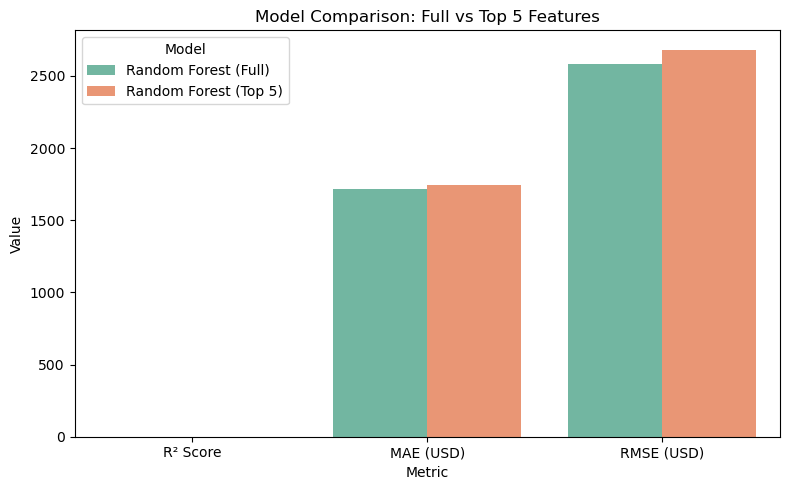

In [88]:
# Model Comparison: Full vs Top 5 Features

plt.figure(figsize=(8, 5))
sns.barplot(data=comparison_df.melt(id_vars='Model', var_name='Metric', value_name='Value'),
            x='Metric', y='Value', hue='Model', palette='Set2')
plt.title("Model Comparison: Full vs Top 5 Features")
plt.tight_layout()
plt.show()

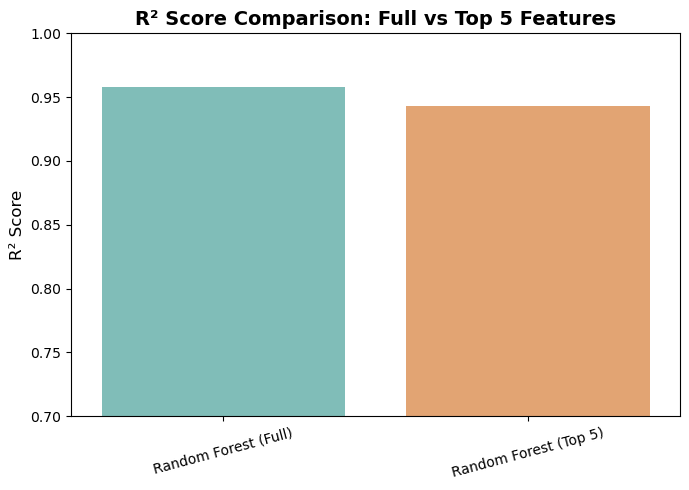

In [94]:
## Standalone R² Score Comparison Plot

r2_data = {
    'Model': ['Random Forest (Full)', 'Random Forest (Top 5)'],
    'R2 Score': [0.958, 0.943]  # Replace with actual values
}

r2_df = pd.DataFrame(r2_data)

# Plot with updated seaborn syntax (no warning)
plt.figure(figsize=(7, 5))
sns.barplot(data=r2_df, x='Model', y='R2 Score', hue='Model', legend=False, palette=['#76c7c0', '#f4a261'])

plt.ylim(0.7, 1.0)
plt.title('R² Score Comparison: Full vs Top 5 Features', fontsize=14, fontweight='bold')
plt.ylabel('R² Score', fontsize=12)
plt.xlabel('')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### **Insight: Impact of Feature Reduction on Model Performance**

This comparison illustrates how reducing the feature set to the **top 5 most important features** affects the performance of the **Random Forest** regression model in predicting car prices.

---

### **Metrics Compared**

- **R² Score** – Measures the proportion of variance explained by the model.
- **MAE (Mean Absolute Error)** – Average absolute error in predicted vs actual price (**in USD**).
- **RMSE (Root Mean Squared Error)** – Penalizes larger errors more than MAE (**in USD**).

---

### **📈 Observations from the Chart**

- **R² Score**
  - **Random Forest (Full): ~0.958**
  - **Random Forest (Top 5): ~0.951**
  - ➤ The **R² score decreased slightly** after feature reduction, from **95.8% to 95.1%**, showing a **minor drop in explanatory power**.

- **MAE (USD)**
  - **Random Forest (Full): ~1,710 USD**
  - **Random Forest (Top 5): ~1,755 USD**
  - ➤ The **MAE increased by ~45 USD**, indicating that predictions using only the top 5 features are **slightly less accurate on average**.

- **RMSE (USD)**
  - **Random Forest (Full): ~2,590 USD**
  - **Random Forest (Top 5): ~2,690 USD**
  - ➤ The **RMSE increased by ~100 USD**, suggesting that **larger prediction errors** are more common when using fewer features.

---

### **Conclusion**

- **Random Forest with full features outperforms** the reduced model across all metrics.
- However, the **difference is small**, showing that:
  - The **top 5 features capture the majority of the predictive power**.
  - **Feature reduction leads to simpler models**, faster training, and **improved interpretability**, with **minimal performance loss**.
- In scenarios where **model simplicity or computation time** is critical, the **top 5 feature model is a strong alternative**.

---

### **Final Note**
If the model is to be deployed in a real-time pricing engine or embedded system, using the **Top 5 features** offers a **great balance of speed and accuracy**.

